In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tqdm import tqdm

In [2]:
# Load InceptionV3 without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False)
model = tf.keras.Model(base_model.input, base_model.layers[-1].output)

In [3]:
def load_and_preprocess_image(img_path):
    # Load image file and resize
    img = image.load_img(img_path, target_size=(299, 299))
    # Convert to array
    img_array = image.img_to_array(img)
    # Expand dims for batch
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess for InceptionV3
    img_array = preprocess_input(img_array)
    return img_array

In [4]:
import glob

# Get all .jpg image paths in the 'images/' folder
image_paths = glob.glob('images/*.jpg')

# Example check
print(f"Found {len(image_paths)} images.")
print("First 3 image paths:", image_paths[:3])

Found 8091 images.
First 3 image paths: ['images\\1000268201_693b08cb0e.jpg', 'images\\1001773457_577c3a7d70.jpg', 'images\\1002674143_1b742ab4b8.jpg']


In [ ]:
# Dictionary to hold image features
image_features = {}

for img_path in tqdm(image_paths):
    img_id = os.path.basename(img_path)
    img_tensor = load_and_preprocess_image(img_path)
    features = model.predict(img_tensor)  # shape: (1, 8, 8, 2048)
    image_features[img_id] = features.squeeze()  # shape: (8, 8, 2048)


In [8]:
# Save each image feature to a .npy file
feature_dir = 'features'
os.makedirs(feature_dir, exist_ok=True)

for img_id, feat in image_features.items():
    np.save(os.path.join(feature_dir, img_id.replace('.jpg', '.npy')), feat)

#### Caption preprocessing

In [5]:
# Load captions.txt and parse it

import pandas as pd
from collections import defaultdict

# Load the captions file
df = pd.read_csv('captions.txt')  # Assuming it's in CSV format with headers: image,caption

# Group captions by image
image_captions = defaultdict(list)

for idx, row in df.iterrows():
    img = row['image']
    caption = row['caption'].strip()
    caption = "<start> " + caption + " <end>"  # Add special tokens
    image_captions[img].append(caption)


In [6]:
# Flatten All Captions for Tokenizer Fitting

all_captions = []
for caps in image_captions.values():
    all_captions.extend(caps)


In [7]:
# Tokenize Captions using Keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set max vocabulary size
VOCAB_SIZE = 5000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\\]^_`{|}~ ')
tokenizer.fit_on_texts(all_captions)

# Save tokenizer for later inference
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Get vocab size (+1 because indexing starts from 1)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)


Vocabulary size: 8497


In [8]:
# Convert Captions to Sequences and Pad

# Optional: get the max length
max_length = max(len(caption.split()) for caption in all_captions)
print("Max caption length:", max_length)

Max caption length: 40


In [9]:
cap_seqs = tokenizer.texts_to_sequences(all_captions)
cap_vector = pad_sequences(cap_seqs, padding='post', maxlen=max_length)

#### Dataset Preparation for Training

In [10]:
# Match Image Features and Captions

import numpy as np

# Rebuild the full list of (img_feature, caption) pairs
image_caption_pairs = []

for img_name, captions in image_captions.items():
    for cap in captions:
        image_caption_pairs.append((img_name, cap))

In [11]:
# Get a list of unique image filenames
unique_images = list(image_captions.keys())

# Reduce to first N images
N = 250  # Try with 500, or reduce further if needed
selected_images = set(unique_images[:N])

# Filter image-caption pairs
reduced_image_caption_pairs = [
    (img, cap)
    for img, cap in image_caption_pairs
    if img in selected_images
]

In [12]:
len(reduced_image_caption_pairs)

1250

In [13]:
# Create Input-Target Sequences
# Load tokenizer if not already in memory
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Reuse vocab size and max length
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

print(vocab_size)
print(max_length)

8497
40


In [14]:
# Store inputs and targets
img_inputs = []
cap_inputs = []
cap_targets = []

for img_name, caption in reduced_image_caption_pairs:
    seq = tokenizer.texts_to_sequences([caption])[0]
    for i in range(1, len(seq)):
        input_seq = seq[:i]              # Caption so far
        target_word = seq[i]             # Next word to predict
        
        input_seq_padded = pad_sequences([input_seq], maxlen=max_length, padding='post')[0]
        
        cap_inputs.append(input_seq_padded)
        cap_targets.append(target_word)

        # Load image feature (.npy)
        img_feature = np.load(os.path.join("features", img_name.replace('.jpg', '.npy')))
        img_inputs.append(img_feature)


In [15]:
img_inputs = np.array(img_inputs)            # shape: (N, 8, 8, 2048)
cap_inputs = np.array(cap_inputs)            # shape: (N, max_len)
cap_targets = np.array(cap_targets)          # shape: (N,)

In [16]:
# Create a TensorFlow Dataset
import tensorflow as tf

BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset = tf.data.Dataset.from_tensor_slices(((img_inputs, cap_inputs), cap_targets))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Step 4: Model Architecture (Encoder + Attention + Decoder)

In [17]:
# Encoder Module

class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim, activation='relu')

    def call(self, x):
        x = tf.reshape(x, (x.shape[0], -1, x.shape[-1]))  # shape: (batch, 64, 2048)
        x = self.fc(x)  # shape: (batch, 64, embedding_dim)
        return x

In [18]:
# Bahdanau Attention Module
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)  # (batch, 1, hidden_dim)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch, embedding_dim)
        return context_vector, attention_weights


In [19]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(units)

    def call(self, x, features, hidden):
        # Attention
        context_vector, attention_weights = self.attention(features, hidden)
        
        # Embedding
        x = self.embedding(x)  # shape: (batch, 1, embedding_dim)

        # Concatenate context with embedding
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # GRU
        output, state = self.gru(x)

        # Output layers
        x = self.fc1(output)     # shape: (batch, 1, units)
        x = tf.reshape(x, (-1, x.shape[2]))  # shape: (batch, units)
        x = self.fc2(x)          # shape: (batch, vocab_size)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [20]:
embedding_dim = 128
units = 256
vocab_size = len(tokenizer.word_index) + 1

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.not_equal(real, 0)  # pad token = 0
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

optimizer = tf.keras.optimizers.Adam()

#### Training Loop

In [22]:
# Prepare Training Step Function

@tf.function
def train_step(img_tensor, target_seq, decoder, encoder, tokenizer, optimizer):
    loss = 0

    # Initialize decoder hidden state
    hidden = decoder.reset_state(batch_size=target_seq.shape[0])

    # Pass image through encoder
    features = encoder(img_tensor)

    # Start token (<start>) as first input to decoder
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target_seq.shape[0], 1)

    with tf.GradientTape() as tape:
        for i in range(1, target_seq.shape[1]):
            # Pass through decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # Accumulate loss
            loss += loss_function(target_seq[:, i], predictions)

            # Use teacher forcing — feed target as next input
            dec_input = tf.expand_dims(target_seq[:, i], 1)

    total_loss = loss / int(target_seq.shape[1])

    # Apply gradients
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return total_loss


In [23]:
# Training loop
EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0

    for (batch, ((img_tensor, target_input), target_output)) in enumerate(dataset):
        batch_loss = train_step(img_tensor, target_input, decoder, encoder, tokenizer, optimizer)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    print(f'Epoch {epoch+1} Loss {total_loss / (batch+1):.6f}')


c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['cnn__encoder/dense/kernel', 'cnn__encoder/dense/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1 Batch 0 Loss 1.7536
Epoch 1 Batch 100 Loss 0.7911
Epoch 1 Batch 200 Loss 0.5125
Epoch 1 Batch 300 Loss 0.4494
Epoch 1 Batch 400 Loss 0.5074
Epoch 1 Loss 0.575719
Epoch 2 Batch 0 Loss 0.5241
Epoch 2 Batch 100 Loss 0.3666
Epoch 2 Batch 200 Loss 0.3937
Epoch 2 Batch 300 Loss 0.3821
Epoch 2 Batch 400 Loss 0.2376
Epoch 2 Loss 0.339116
Epoch 3 Batch 0 Loss 0.4892
Epoch 3 Batch 100 Loss 0.2416
Epoch 3 Batch 200 Loss 0.2974
Epoch 3 Batch 300 Loss 0.2326
Epoch 3 Batch 400 Loss 0.2460
Epoch 3 Loss 0.248171
Epoch 4 Batch 0 Loss 0.2136
Epoch 4 Batch 100 Loss 0.1888
Epoch 4 Batch 200 Loss 0.1568
Epoch 4 Batch 300 Loss 0.2015
Epoch 4 Batch 400 Loss 0.1857
Epoch 4 Loss 0.191838
Epoch 5 Batch 0 Loss 0.3159
Epoch 5 Batch 100 Loss 0.1843
Epoch 5 Batch 200 Loss 0.1939
Epoch 5 Batch 300 Loss 0.1886
Epoch 5 Batch 400 Loss 0.1493
Epoch 5 Loss 0.156686


#### Inference - Generate Caption for a New Image

##### Preprocess the New Image

In [24]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [25]:
def extract_image_features(image_path, image_model):
    img, _ = load_image(image_path)
    img = tf.expand_dims(img, 0)  # shape: (1, 299, 299, 3)
    features = image_model(img)   # shape: (1, 8, 8, 2048)
    return features

##### Generate Caption Function

In [26]:
def generate_caption(image_path, encoder, decoder, tokenizer, image_model, max_length=50):
    # Extract and encode image features
    features = extract_image_features(image_path, image_model)
    features = encoder(features)  # shape: (1, 64, embedding_dim)

    # Initialize decoder
    hidden = decoder.reset_state(batch_size=1)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    result = []
    attention_plot = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # Save attention if you want to visualize later
        attention_plot.append(attention_weights.numpy().reshape(-1))

        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = tokenizer.index_word.get(predicted_id, '')

        if predicted_word == '<end>':
            break

        result.append(predicted_word)

        # Use predicted word as next input
        dec_input = tf.expand_dims([predicted_id], 0)

    return ' '.join(result), attention_plot


##### Usage Example

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image_with_caption(image_path, caption):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=12, wrap=True)
    plt.show()

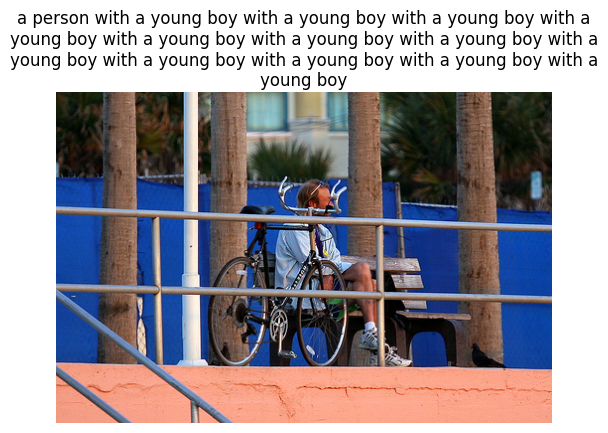

In [28]:
# Generate caption
caption, _ = generate_caption("Images/485312202_784508f2a9.jpg", encoder, decoder, tokenizer, model)

# Show image and caption
show_image_with_caption("Images/485312202_784508f2a9.jpg", caption)

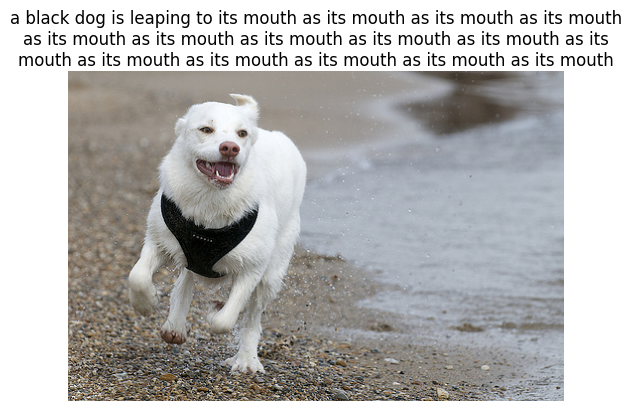

In [ ]:
# Generate caption
caption, _ = generate_caption("Images/3535284878_f90f10236e.jpg", encoder, decoder, tokenizer, model)

# Show image and caption
show_image_with_caption("Images/3535284878_f90f10236e.jpg", caption)

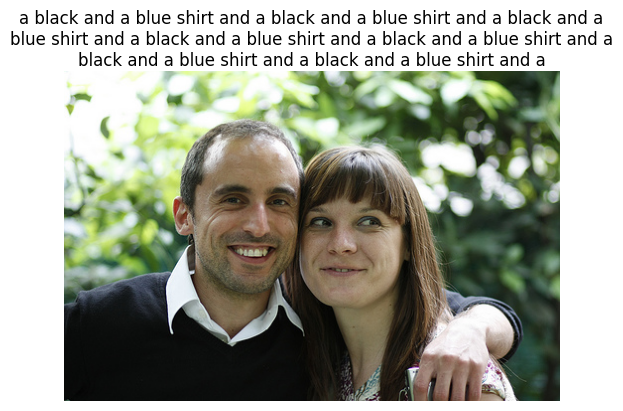

In [34]:
# Generate caption
caption, _ = generate_caption("Images/3589052481_059e5e2c37.jpg", encoder, decoder, tokenizer, model)

# Show image and caption
show_image_with_caption("Images/3589052481_059e5e2c37.jpg", caption)

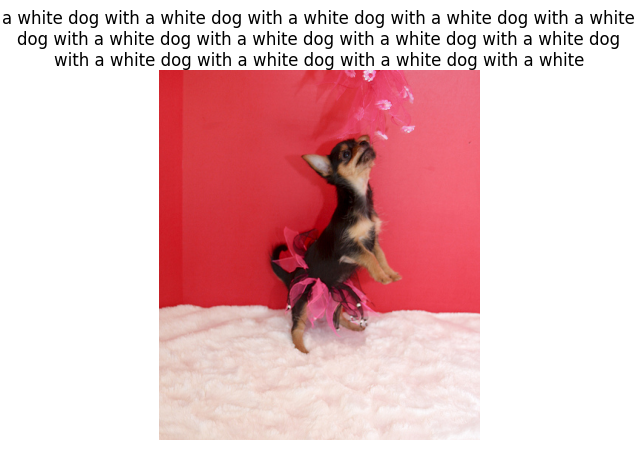

In [37]:
# Generate caption
caption, _ = generate_caption("Images/3720366614_dfa8fe1088.jpg", encoder, decoder, tokenizer, model)

# Show image and caption
show_image_with_caption("Images/3720366614_dfa8fe1088.jpg", caption)

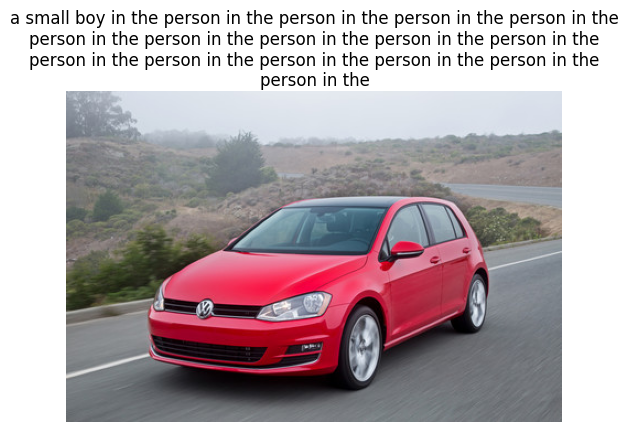

In [41]:
# Generate caption
caption, _ = generate_caption("Test_Images/auto.jpg", encoder, decoder, tokenizer, model)

# Show image and caption
show_image_with_caption("Test_Images/auto.jpg", caption)

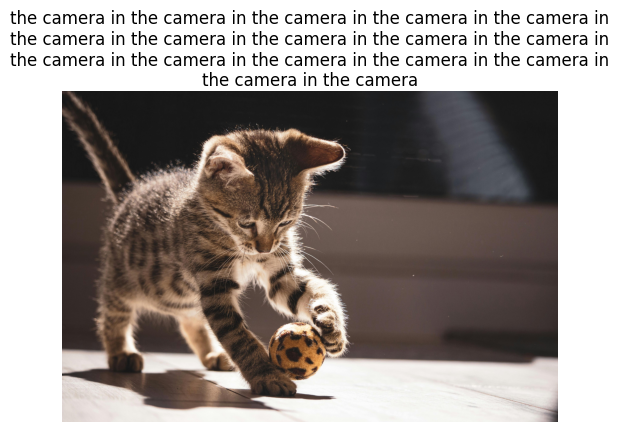

In [42]:
# Generate caption
caption, _ = generate_caption("Test_Images/gato_jugando.jpg", encoder, decoder, tokenizer, model)

# Show image and caption
show_image_with_caption("Test_Images/gato_jugando.jpg", caption)

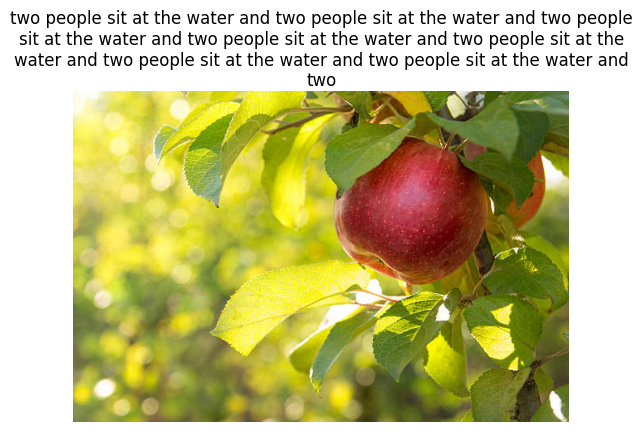

In [43]:
# Generate caption
caption, _ = generate_caption("Test_Images/manzana.jpg", encoder, decoder, tokenizer, model)

# Show image and caption
show_image_with_caption("Test_Images/manzana.jpg", caption)